In [1]:
import sys
sys.path.append('..')
import json
import help_functions as hf
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
hf.setup_gpu(gpu_nr=1)

2 Physical GPUs, 1 Logical GPU


In [2]:
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(11)]

train, train_df = hf.get_flow(df_file=config['data_folder'] + '/test_df.json.bz2',
                   nr_classes=config['nr_classes'],
                   batch_size=config['batch_size'],
                   image_dimension=config['image_dimension'])
y_true = hf.get_y_true(shape=(train.samples, len(train.class_indices)), classes=train.classes)
label_names = list(train.class_indices.keys())

Found 50000 non-validated image filenames belonging to 40 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 49514 validated image filenames belonging to 20 classes.


In [3]:
hf.compute_class_weights(y_true)

{0: 3.0414004914004913,
 1: 1.651567711807872,
 2: 5.825176470588235,
 3: 0.19865992617557374,
 4: 1.308509513742072,
 5: 0.8130377668308703,
 6: 0.28404084442404776,
 7: 7.594171779141104,
 8: 2.3137383177570094,
 9: 5.770862470862471,
 10: 0.3117617428535449,
 11: 0.23768241167434717,
 12: 0.23627600687154038,
 13: 0.12418861299222474,
 14: 3.541773962804006,
 15: 0.981252477209671,
 16: 5.501555555555556,
 17: 0.14122646891043925,
 18: 1.0712678494158372,
 19: 1.0175503493629263}

In [4]:
name_id_map = train.class_indices
class_names = len(name_id_map)*[0]
for k in name_id_map.keys():
    class_names[name_id_map[k]] = k

In [5]:
weights = train_df[["labels", "title"]].explode("labels")\
            .groupby("labels").agg("count").reset_index()
total = weights.title.sum()
weights['proportion'] = weights.title.apply(lambda r: r/total)
weights['weight'] = weights.title.apply(lambda r: (1/r)*(total/41)) # 
# weights['weight'] = weights.page_title.apply(lambda r: np.log((1/r)*(total/2)))
weights = weights[['labels', 'proportion', 'weight']]
class_weight = {}
for l in name_id_map.keys():
    w = weights[weights.labels==l].weight.iloc[0]
    class_weight[train.class_indices[l]] = w


In [6]:
class_weight

{0: 3.1579672799184992,
 1: 1.7148668217836278,
 2: 6.048436154949784,
 3: 0.20627390193016035,
 4: 1.3586603413602847,
 5: 0.8441988065200849,
 6: 0.2949271874545271,
 7: 7.88523118360018,
 8: 2.4024162297697744,
 9: 5.9920404798453575,
 10: 0.32371053593422217,
 11: 0.246791989809299,
 12: 0.24533168217729132,
 13: 0.1289483504315856,
 14: 3.677518406085348,
 15: 1.0188606285587232,
 16: 5.712411924119241,
 17: 0.14663921083021442,
 18: 1.112325991282414,
 19: 1.0565496777039287}

In [59]:
mean_ir_original, dict_ir_original = hf.mean_imbalance_ratio(y_true=y_true, class_names=label_names)
print(f'mean_ir_original: {mean_ir_original}')

original_nr_rows = y_true.shape[0]
nr_labels = y_true.shape[1]
y_true_copy = np.copy(y_true)
indices_to_add = []

mean_ir_original: 16.55546720387189


In [60]:
BIG_NUMBER = 10_000
label_rewards = BIG_NUMBER / y_true_copy.sum(axis=0)
row_rewards = (label_rewards * y_true_copy).sum(axis=1)


In [62]:
reps = 50
while y_true_copy.shape[0] < original_nr_rows * (1 + add_pctg):
    
    best_row = y_true_copy[np.argmax(row_rewards), :].reshape(1, nr_labels) # 1.5 ms on average
    y_true_copy = np.append(y_true_copy, np.tile(best_row, (reps, 1)), axis=0) # 50 ms on average

    label_rewards = BIG_NUMBER / y_true_copy.sum(axis=0) # 20 ms on average
    row_rewards = (label_rewards * y_true_copy).sum(axis=1) # 80 ms on average

    idx_to_add = np.where((y_true == best_row).all(axis=1))[0] # 40 ms on average
    for _ in range(reps):
        indices_to_add.append(idx_to_add[0]) # 0.05 ms on average

mean_ir_heuristics, dict_ir_heuristics = hf.mean_imbalance_ratio(y_true=y_true_copy, class_names=label_names)

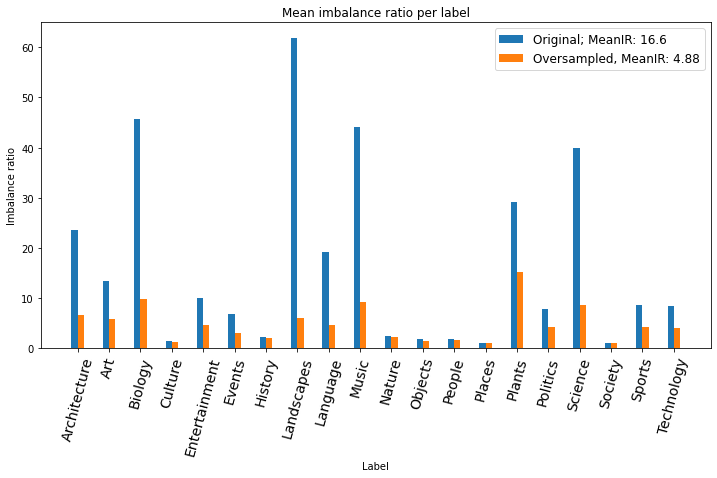

In [63]:

plt.figure(figsize=(12, 6))
x_axis = np.arange(len(dict_ir_original.keys()))
plt.bar(x_axis-0.1, dict_ir_original.values(), width=0.2, label=f'Original; MeanIR: {np.round(mean_ir_original, 1)}')
plt.bar(x_axis+0.1, dict_ir_heuristics.values(), width=0.2, label=f'Oversampled, MeanIR: {np.round(mean_ir_heuristics, 2)}')
plt.legend(fontsize=12)
_ = plt.xticks(x_axis, dict_ir_heuristics.keys(), rotation=75, fontsize=14)
plt.title('Mean imbalance ratio per label')
plt.ylabel('Imbalance ratio')
plt.xlabel('Label')
plt.show()
# hf.save_img(image_path + '/oversampled_imbalance_ratios.png')

In [84]:
indices_to_add_hashable = [tuple([el]) for el in indices_to_add]
duplicate_indices_dict = dict(Counter(indices_to_add_hashable))

In [89]:
for index_to_duplicate in duplicate_indices_dict:
    print(index_to_duplicate)
    times_to_duplicate = duplicate_indices_dict[index_to_duplicate]
    train_df = pd.concat([train_df, pd.DataFrame([train_df.iloc[index_to_duplicate]] * times_to_duplicate)], axis=0, ignore_index=True)


(21659,)
(479325,)
(267699,)
(30992,)
(199574,)
(184219,)
(560944,)
(579772,)
(574684,)
(439750,)
(281554,)


In [6]:
train, _ = hf.get_flow(df=train_df,
                    nr_classes=config['nr_classes'],
                    image_dimension=config['image_dimension'])

Found 59417 non-validated image filenames belonging to 20 classes.
Found 59417 validated image filenames belonging to 20 classes.
